# Notebook: Processamento de Sinais com Filtros

## Exercício 1

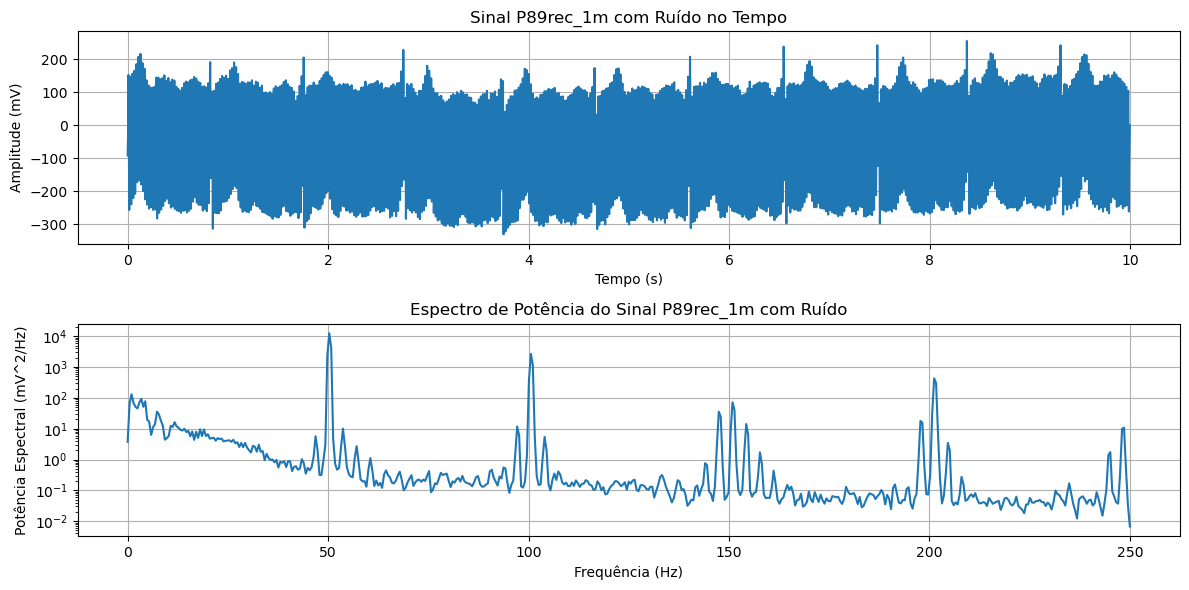

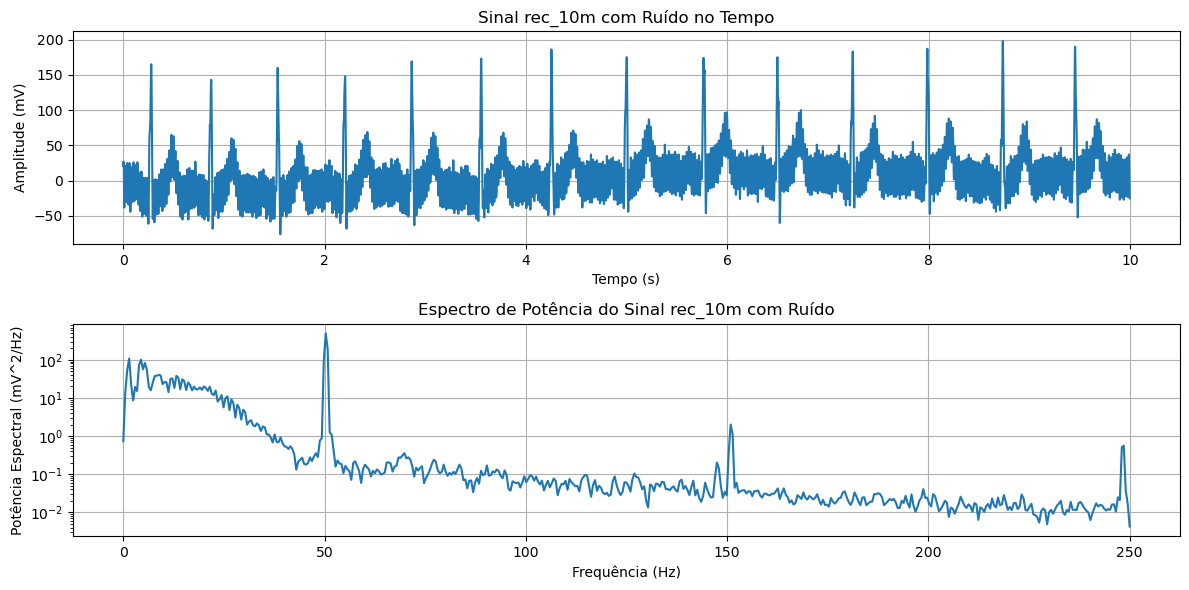

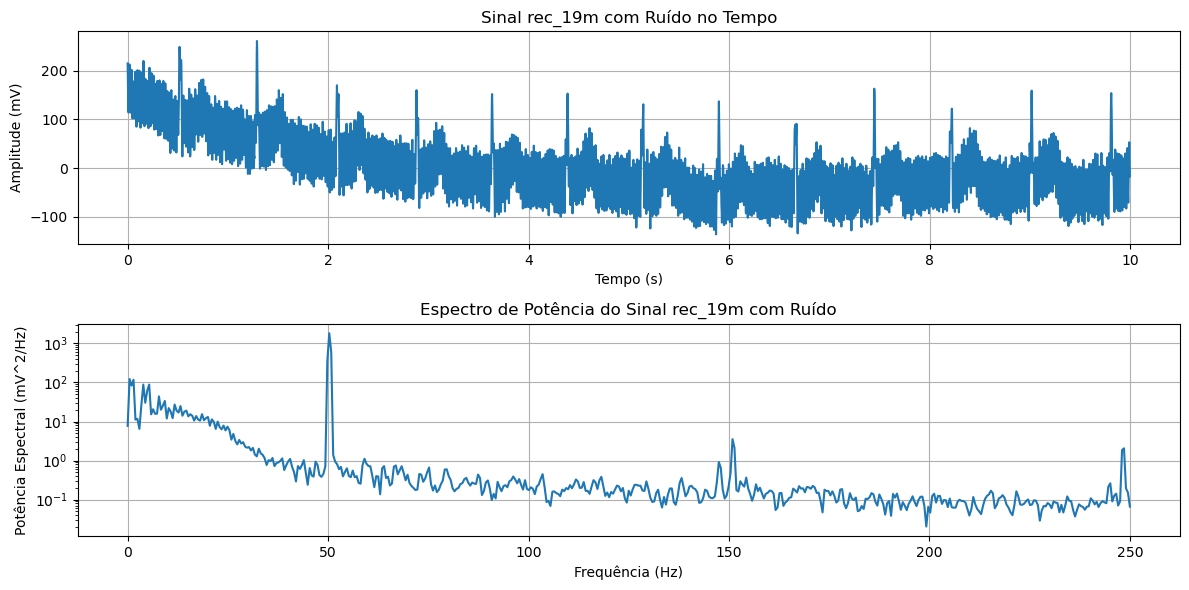

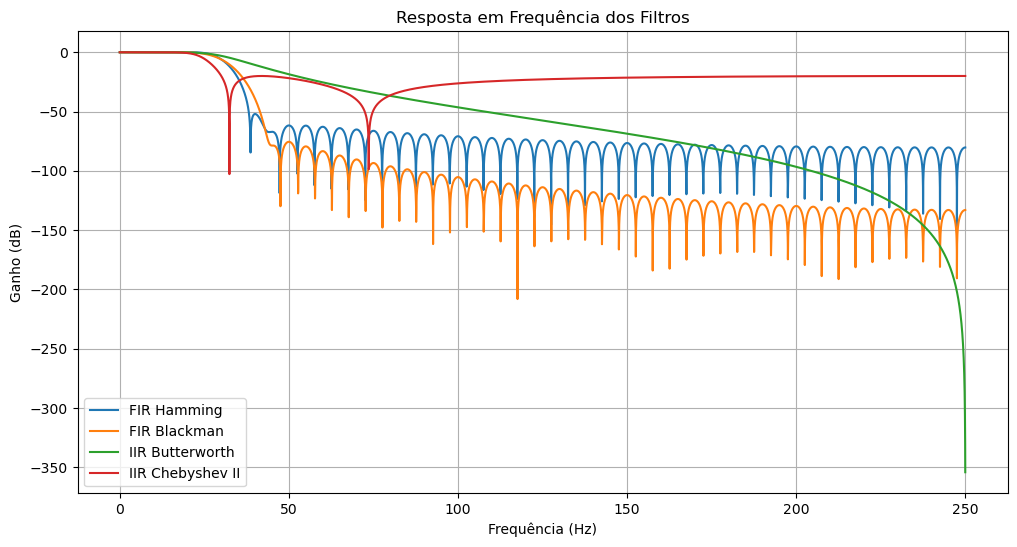

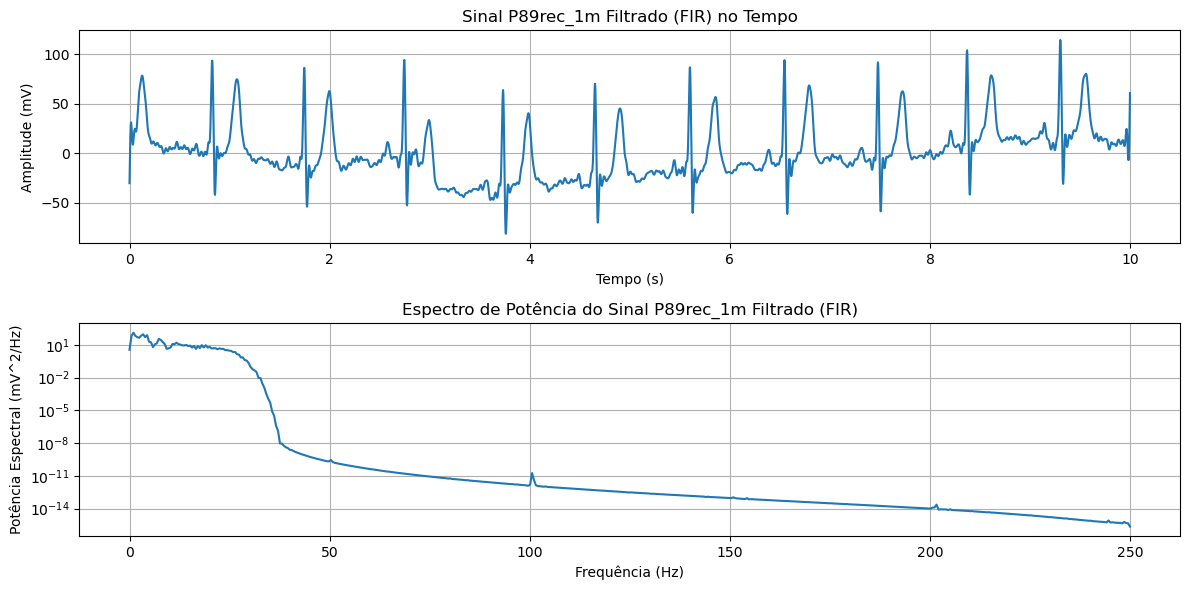

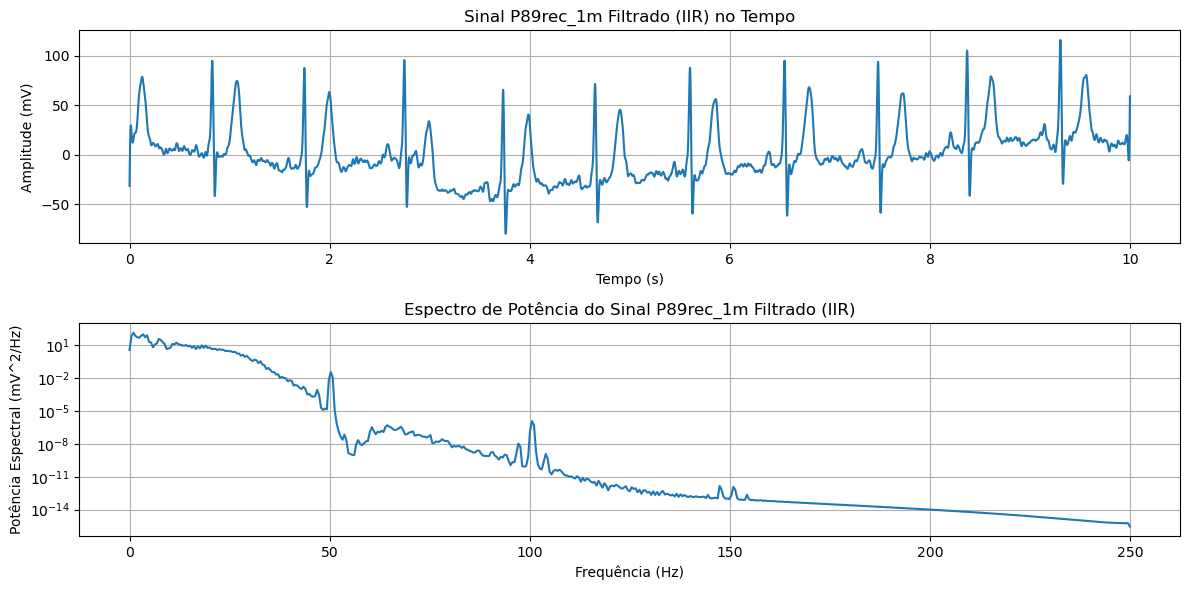

In [3]:
# Importação das bibliotecas necessárias
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import firwin, iirfilter, freqz, filtfilt, welch

# Verificar se o diretório "Resultados" existe; se não, cria-lo
output_dir = 'Resultados'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Carregar os dados dos arquivos .mat
data_files = {
    'P89rec_1m': loadmat('Dados/P89rec_1m.mat')['val'],
    'rec_10m': loadmat('Dados/rec_10m.mat')['val'],
    'rec_19m': loadmat('Dados/rec_19m.mat')['val']
}

# Parâmetros de amostragem
Fs = 500  # Frequência de amostragem em Hz
T = 1 / Fs  # Período de amostragem

# Função para plotar sinais no tempo e seu espectro e salvar a imagem
def plot_signal_and_spectrum(data, title):
    n = len(data)
    t = np.arange(n) / Fs
    
    # Plot do sinal no domínio do tempo
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, data)
    plt.title(f'Sinal {title} no Tempo')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    
    # Calcular o espectro usando Welch
    f, Pxx = welch(data, Fs, nperseg=1024)
    plt.subplot(2, 1, 2)
    plt.semilogy(f, Pxx)
    plt.title(f'Espectro de Potência do Sinal {title}')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Potência Espectral (mV^2/Hz)')
    plt.grid(True)
    plt.tight_layout()
    
    # Salvar a imagem na pasta "Resultados"
    plt.savefig(os.path.join(output_dir, f'{title}.png'))
    plt.show()

# Plot dos sinais originais com ruído
plot_signal_and_spectrum(data_files['P89rec_1m'][0], 'P89rec_1m com Ruído')
plot_signal_and_spectrum(data_files['rec_10m'][0], 'rec_10m com Ruído')
plot_signal_and_spectrum(data_files['rec_19m'][0], 'rec_19m com Ruído')

# Função para aplicar filtros e plotar a resposta em frequência e salvar a imagem
def filter_design_and_plot(Fs):
    # Filtros FIR - Passa-baixa
    nyquist = Fs / 2
    fir_hamming = firwin(numtaps=101, cutoff=30, window='hamming', fs=Fs)
    fir_blackman = firwin(numtaps=101, cutoff=30, window='blackman', fs=Fs)

    # Filtros IIR - Passa-baixa
    iir_butter = iirfilter(N=4, Wn=30 / nyquist, btype='low', ftype='butter')
    iir_cheby2 = iirfilter(N=4, Wn=30 / nyquist, btype='low', ftype='cheby2', rs=20)

    # Plot da resposta em frequência dos filtros
    plt.figure(figsize=(12, 6))
    
    # FIR Hamming
    w, h = freqz(fir_hamming, worN=8000, fs=Fs)
    plt.plot(w, 20 * np.log10(abs(h)), label='FIR Hamming')

    # FIR Blackman
    w, h = freqz(fir_blackman, worN=8000, fs=Fs)
    plt.plot(w, 20 * np.log10(abs(h)), label='FIR Blackman')

    # IIR Butterworth
    w, h = freqz(iir_butter[0], iir_butter[1], worN=8000, fs=Fs)
    plt.plot(w, 20 * np.log10(abs(h)), label='IIR Butterworth')

    # IIR Chebyshev II
    w, h = freqz(iir_cheby2[0], iir_cheby2[1], worN=8000, fs=Fs)
    plt.plot(w, 20 * np.log10(abs(h)), label='IIR Chebyshev II')

    plt.title('Resposta em Frequência dos Filtros')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Ganho (dB)')
    plt.grid(True)
    plt.legend()
    
    # Salvar a imagem na pasta "Resultados"
    plt.savefig(os.path.join(output_dir, 'Resposta_em_Frequencia_dos_Filtros.png'))
    plt.show()

# Plot da resposta em frequência dos filtros
filter_design_and_plot(Fs)

# Aplicação dos filtros aos sinais com ajuste de nível DC e rejeição de ruído 50/60 Hz se necessário
def apply_filters(data, Fs):
    # Ajuste de nível DC
    data = data - np.mean(data)
    
    # Filtro FIR de rejeição de 50/60 Hz
    notch_filter = firwin(numtaps=101, cutoff=[49, 61], pass_zero=True, fs=Fs)
    filtered_data_notch = filtfilt(notch_filter, [1], data)
    
    # Aplicação dos filtros de passa-baixa
    fir_hamming = firwin(numtaps=101, cutoff=30, window='hamming', fs=Fs)
    filtered_data_fir = filtfilt(fir_hamming, [1], filtered_data_notch)
    
    iir_butter_b, iir_butter_a = iirfilter(N=4, Wn=30 / (Fs / 2), btype='low', ftype='butter')
    filtered_data_iir = filtfilt(iir_butter_b, iir_butter_a, filtered_data_notch)
    
    return filtered_data_fir, filtered_data_iir

# Filtragem dos sinais
filtered_fir, filtered_iir = apply_filters(data_files['P89rec_1m'][0], Fs)

# Plot dos sinais filtrados
plot_signal_and_spectrum(filtered_fir, 'P89rec_1m Filtrado (FIR)')
plot_signal_and_spectrum(filtered_iir, 'P89rec_1m Filtrado (IIR)')

## Exercício 2

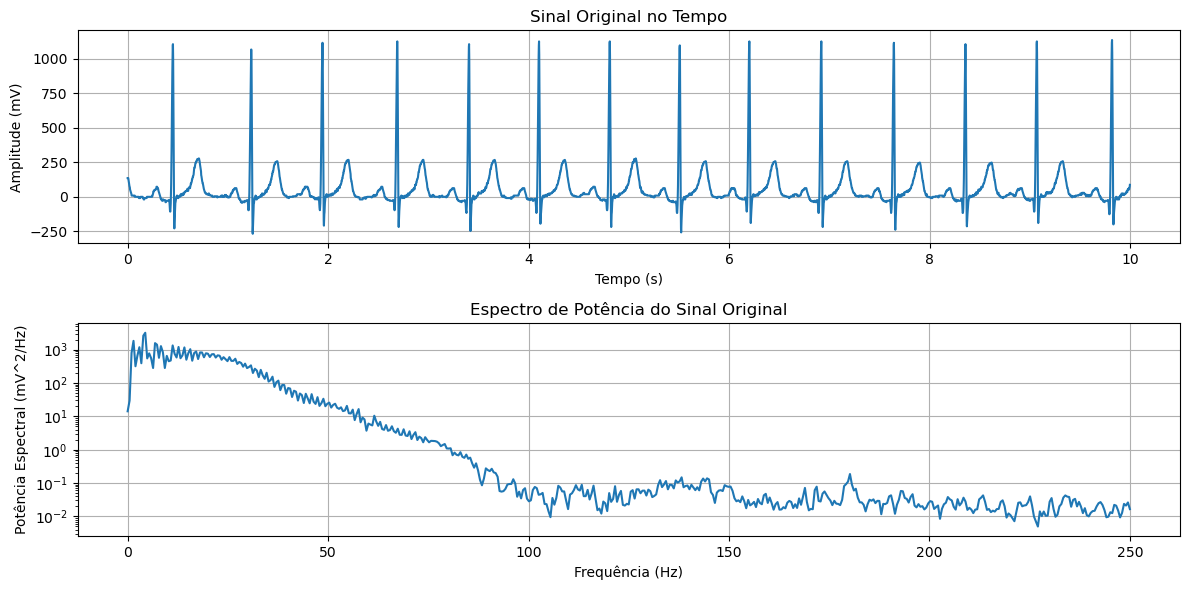

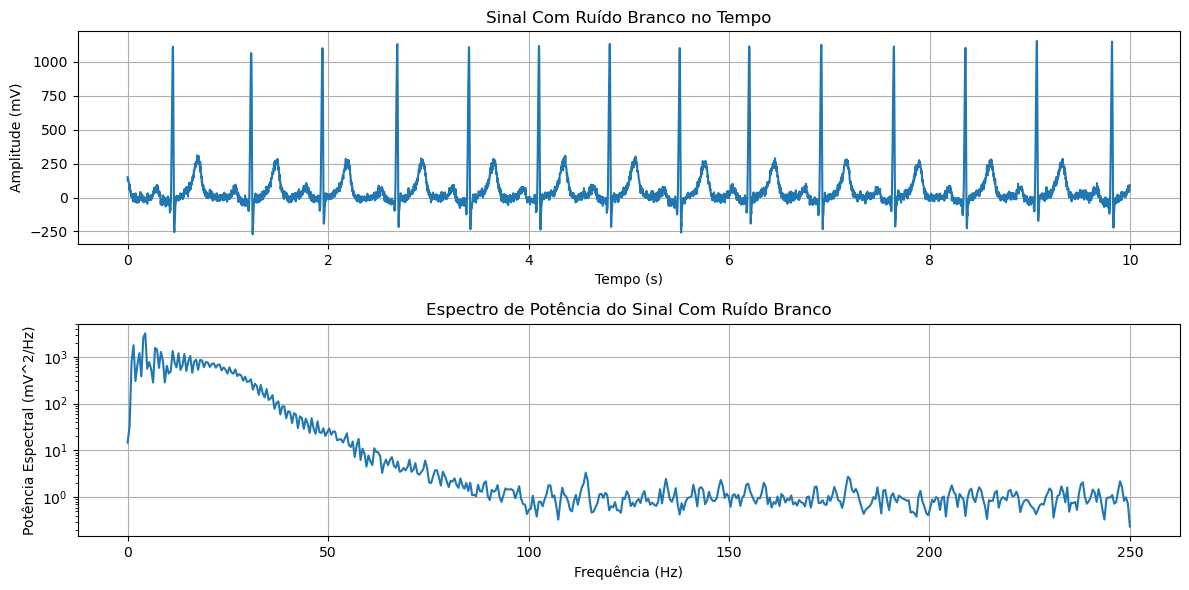

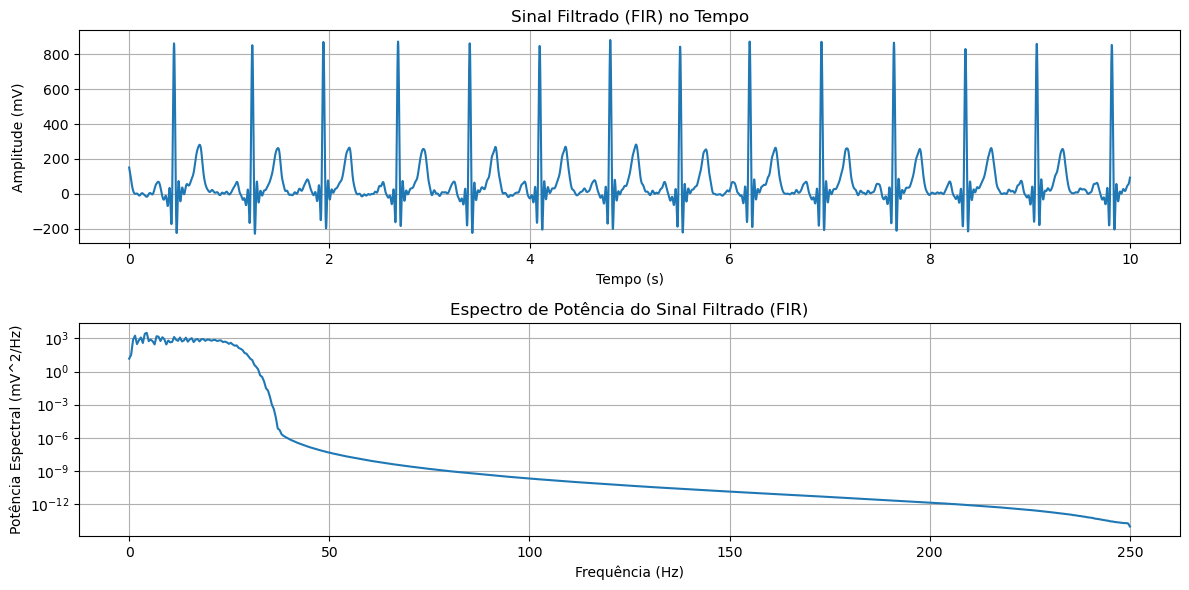

In [4]:
# Importação das bibliotecas necessárias
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import welch, filtfilt, firwin

# Verificar se o diretório "Resultados" existe; se não, cria-lo
output_dir = 'Resultados'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Carregar o dado do arquivo .mat
data_file = loadmat('Dados/E00001.mat')['val']

# Selecionar uma das derivações (por exemplo, derivação I)
data = data_file[0]  # Utilizando a derivação I (primeira linha do array)

# Parâmetros de amostragem
Fs = 500  # Frequência de amostragem em Hz
G = 1000  # Ganho

# Função para plotar sinal no tempo e seu espectro e salvar a imagem
def plot_signal_and_spectrum(data, title):
    n = len(data)
    t = np.arange(n) / Fs
    
    # Plot do sinal no domínio do tempo
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, data)
    plt.title(f'Sinal {title} no Tempo')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    
    # Calcular o espectro usando Welch
    f, Pxx = welch(data, Fs, nperseg=1024)
    plt.subplot(2, 1, 2)
    plt.semilogy(f, Pxx)
    plt.title(f'Espectro de Potência do Sinal {title}')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Potência Espectral (mV^2/Hz)')
    plt.grid(True)
    plt.tight_layout()
    
    # Salvar a imagem na pasta "Resultados"
    plt.savefig(os.path.join(output_dir, f'{title}.png'))
    plt.show()

# Plot do sinal original no tempo e espectro
plot_signal_and_spectrum(data, 'Original')

# Adicionar ruído branco ou rosa
def add_noise(data, noise_type='white', snr_db=20):
    if noise_type == 'white':
        # Gerar ruído branco
        noise = np.random.normal(0, np.std(data) / (10**(snr_db / 20)), data.shape)
    elif noise_type == 'pink':
        # Gerar ruído rosa usando método de filtragem
        white_noise = np.random.normal(0, np.std(data) / (10**(snr_db / 20)), data.shape)
        b = [0.049922035, -0.095993537, 0.050612699, -0.004408786]  # Coeficientes para aproximar ruído rosa
        noise = filtfilt(b, 1, white_noise)
    else:
        raise ValueError("Tipo de ruído inválido. Escolha 'white' ou 'pink'.")
    
    noisy_data = data + noise
    return noisy_data

# Adicionar ruído branco ao sinal
data_noisy = add_noise(data, noise_type='white', snr_db=20)

# Plot do sinal com ruído no tempo e espectro
plot_signal_and_spectrum(data_noisy, 'Com Ruído Branco')

# Projeto do filtro - FIR passa-baixa para remover o ruído
nyquist = Fs / 2
cutoff_freq = 30  # Freqüência de corte para passa-baixa
numtaps = 101  # Número de coeficientes do filtro

fir_filter = firwin(numtaps, cutoff=cutoff_freq, fs=Fs, window='hamming')

# Aplicar o filtro ao sinal com ruído
data_filtered = filtfilt(fir_filter, [1], data_noisy)

# Plot do sinal filtrado no tempo e espectro
plot_signal_and_spectrum(data_filtered, 'Filtrado (FIR)')